## Predictiong an outcome with decision trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
%matplotlib inline

## Preprocess dataset

In [66]:
ds = pd.read_csv("../output/binary.csv", low_memory=False)

to_remove = [
    'entity_id',
    'FECHA_NACIMIENTO',
    'PAIS_NACIMIENTO',
    'MUNICIPIO_NACIMIENTO',
    'PROVINCIA_RESIDENCIA',
    'MUNICIPIO_RESIDENCIA',
    'CALC_AVG_PESO',
    'CALC_AVG_HEIGHT',
    'CALC_AVG_CINTURA',
    'CALC_AVG_CADERA',
    'ENFERMEDADES_DIABETES_T2DM',
    'ENFERMEDADES_DIABETES_GESTACIONAL',
    'ENFERMEDADES_DIABETES_T1DM'
]

ds = ds.drop(to_remove, axis=1)

In [67]:
ds = ds[np.isfinite(ds['EDAD_ANOS'])]
ds = ds[np.isfinite(ds['BMI'])]
ds = ds[np.isfinite(ds['WHR'])]
ds = ds[np.isfinite(ds['SEXO'])]
ds = ds[np.isfinite(ds['PREDIMED'])]
ds = ds[np.isfinite(ds['CALC_AVG_SYSTOLIC_BP'])]
ds = ds[np.isfinite(ds['CALC_AVG_DIASTOLIC_BP'])]
ds = ds[np.isfinite(ds['CALC_AVG_PULSE_RATE'])]

In [68]:
outcome = 'ENFERMEDADES_DIABETES'
ds = ds[~ds[outcome].isnull()]

In [69]:
ds = ds.fillna(-1)

## Split onto training & test dataset

In [70]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(ds, train_size = 0.8)

In [71]:
y_train = train[outcome]
X_train = train.drop(outcome, 1)

y_test = test[outcome]
X_test = test.drop(outcome, 1)

## Train decision tree

In [72]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import cross_validation
from sklearn import tree
from sklearn import grid_search
from sklearn.metrics import roc_auc_score

parameters = {'max_depth': np.arange(1, 10), 'min_samples_split': np.arange(1, 100, 10)}
clf = grid_search.GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, scoring='roc_auc')
clf.fit(X=X_train, y=y_train)

tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

0.70683003982 {'max_depth': 8, 'min_samples_split': 61}


In [73]:
features = X_train.columns[tree_model.feature_importances_ > 0]
importances = tree_model.feature_importances_[tree_model.feature_importances_ > 0]

feature_model = pd.Series(importances, index=features).sort_values(axis=0, ascending=False)
feature_model

WHR                                        0.133482
ENFERMEDADES_HTA                           0.099431
CALC_AVG_PULSE_RATE                        0.091939
CRIBADO_HECES_EDAD                         0.063408
EDAD_ANOS                                  0.050669
ESTADO_PESO_MAXIMO                         0.047443
LABORAL_NUMERO_DE_EMPLEOS_ANO              0.042969
CALC_AVG_SYSTOLIC_BP                       0.041047
CALC_AVG_DIASTOLIC_BP                      0.036613
LABORAL_ESTADO_5                           0.027411
ESTADO_CIVIL_4                             0.025791
INGRESOS_0                                 0.022855
ESTUDIOS_4                                 0.019717
ENFERMEDADES_HIPERCOLESTEROLEMIA           0.019615
BMI                                        0.019232
FAMILIA_PADRE_EDAD                         0.018348
ESTADO_PESO_MINIMO                         0.014666
CONVIVENCIA_HOGAR_5                        0.014093
ENFERMEDADES_CANCER                        0.013661
SALUD_HOMBRE

## Report on test set

In [74]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

tree_preds = tree_model.predict_proba(X_test)[:, 1]
tree_performance = roc_auc_score(y_test, tree_preds)

DecisionTree: Area under the ROC curve = 0.6601741116026831


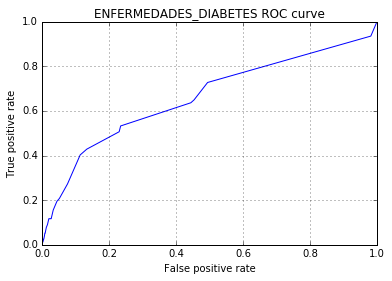

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, tree_preds)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('%s ROC curve' % outcome)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)
print('DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

## Evaluate quality of the predictions

### Distribition of the predictions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f354ebad080>]], dtype=object)

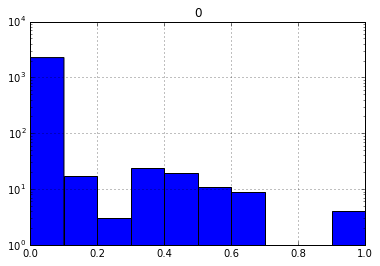

In [76]:
pd.DataFrame(tree_preds).hist(log=True)

### Confusion matrix

Confusion matrix, without normalization
[[2217   58]
 [  68    9]]


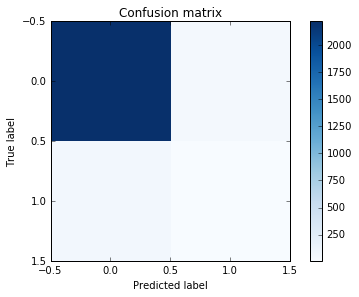

In [77]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = (tree_preds > 0.30)
    
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

## Draw classification tree

In [78]:
import os

filename = '../output/t2dm.dot'
with open(filename, 'w') as f:
    f = tree.export_graphviz(tree_model, out_file=f, feature_names=X_test.columns)

[GraphvizOnline](http://dreampuf.github.io/GraphvizOnline/)